In [78]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [79]:
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel,TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

In [80]:
TIME_COL = "Date"
TARGET = "Weekly_Sales"
STATIC_COV = ["Store", "Dept", "Type", "Size"]
DYNAMIC_COV_FILL_0 = ["IsHoliday", 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
DYNAMIC_COV_FILL_INTERPOLATE = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FREQ = "W-FRI"
FORECAST_HORIZON = 16 # weeks
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [81]:
df = pd.read_csv('data/train.csv')
store_info = pd.read_csv('data/stores.csv')
exo_feat = pd.read_csv('data/features.csv').drop(columns='IsHoliday')

In [82]:
# join all data frames
df = pd.merge(df, store_info, on=['Store'], how='left')
df = pd.merge(df, exo_feat, on=['Store', TIME_COL], how='left')

In [83]:
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df[TARGET] = np.where(df[TARGET] < 0, 0, df[TARGET]) # remove negative values
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5']].fillna(0) # fill missing values with nan
df["IsHoliday"] = df["IsHoliday"]*1 # convert boolean into binary
df["Size"] = np.where(df["Size"] < store_info["Size"].quantile(0.25), "small",
                np.where(df["Size"] > store_info["Size"].quantile(0.75), "large",
"medium")) # make size a categorical variable

In [84]:
df['id']=df['Store'].astype(str) + '-'+ df['Dept'].astype(str)

df.groupby('id').agg({'Date':'count'}).reset_index().sort_values(by='Date')

result = df.groupby('id').agg({'Date':'count'}).reset_index()
result = result[result['Date'] == 143].sort_values(by='Date')
result

,id,Date
0,1-1,143
2162,35-42,143
2163,35-44,143
2165,35-46,143
2168,35-5,143
...,...,...
1069,21-82,143
1070,21-83,143
1071,21-85,143
1073,21-9,143


In [85]:
df = df[df['id'].isin(result['id'])]

In [86]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
0,1,1,2010-02-05,24924.50,0,A,medium,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,1-1
1,1,1,2010-02-12,46039.49,1,A,medium,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,1-1
2,1,1,2010-02-19,41595.55,0,A,medium,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,1-1
3,1,1,2010-02-26,19403.54,0,A,medium,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,1-1
4,1,1,2010-03-05,21827.90,0,A,medium,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421430,45,97,2012-09-28,6269.73,0,B,medium,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,45-97
421431,45,97,2012-10-05,6573.18,0,B,medium,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,45-97
421432,45,97,2012-10-12,6463.32,0,B,medium,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,45-97
421433,45,97,2012-10-19,5575.90,0,B,medium,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,45-97


In [87]:
# reduce running time by forecasting only top 7 stores
top_7_stores = df.groupby(['Store']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(7)
df = df[df['Store'].isin(top_7_stores['Store'])]

In [88]:

df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [89]:
unique_ids = df['id'].nunique()

print(f"Número de valores diferentes na coluna 'id': {unique_ids}")

Número de valores diferentes na coluna 'id': 471


External Regressors

In [90]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


scaler_regressors = StandardScaler()
regressors = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 
              'Unemployment']

forecasts = []

for id_value in df['id'].unique():
    df_id = df[df['id'] == id_value]
    df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

    
    scaler_regressors = StandardScaler()
    df_id[regressors] = scaler_regressors.fit_transform(df_id[regressors])

    model = Prophet()
    for regressor in regressors:
        model.add_regressor(regressor)

    model.fit(df_id[:-16])
    
    future_dates = model.make_future_dataframe(periods=16, freq=FREQ)

    future_dates=pd.merge(future_dates,df_id[['ds','IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                   'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','id']],on='ds',how='inner')

    forecast = model.predict(future_dates)
    forecasts.append(forecast)


full_forecast = pd.concat(forecasts, ignore_index=True)

full_forecast



/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_12628/1475026357.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_12628/1475026357.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id[regressors] = scaler_regressors.fit_transform(df_id[regressors])
15:12:32 - cmdstanpy - INFO - Chain [1] start processing
15:12:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipyker

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,36830.983916,35932.399227,58454.318678,36830.983916,36830.983916,-2411.445749,-2411.445749,-2411.445749,-40.527504,...,-3606.352719,-3606.352719,-3606.352719,13546.662367,13546.662367,13546.662367,0.0,0.0,0.0,46771.293564
1,2010-02-12,36740.609936,40765.082637,64768.996174,36740.609936,36740.609936,-2325.360692,-2325.360692,-2325.360692,-42.133701,...,-5938.257102,-5938.257102,-5938.257102,21981.905511,21981.905511,21981.905511,0.0,0.0,0.0,52784.258346
2,2010-02-19,36650.235957,40265.282511,63532.718517,36650.235957,36650.235957,-2297.432883,-2297.432883,-2297.432883,-44.409148,...,-3498.688271,-3498.688271,-3498.688271,18822.919915,18822.919915,18822.919915,0.0,0.0,0.0,51974.467601
3,2010-02-26,36559.861977,27951.424956,51057.777610,36559.861977,36559.861977,-2279.197948,-2279.197948,-2279.197948,-41.263677,...,-3445.683823,-3445.683823,-3445.683823,6262.283362,6262.283362,6262.283362,0.0,0.0,0.0,39376.461515
4,2010-03-05,36469.487997,14462.350361,37575.089001,36469.487997,36469.487997,-2260.962955,-2260.962955,-2260.962955,-36.980484,...,-3417.886740,-3417.886740,-3417.886740,-7207.740786,-7207.740786,-7207.740786,0.0,0.0,0.0,25843.860471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67348,2012-09-28,11060.719158,7099.584367,10328.372464,11060.716193,11060.722092,139.487221,139.487221,139.487221,32.504829,...,-241.199430,-241.199430,-241.199430,-2011.410587,-2011.410587,-2011.410587,0.0,0.0,0.0,8808.109141
67349,2012-10-05,11052.875670,7938.419357,11231.958342,11052.872362,11052.879043,142.345530,142.345530,142.345530,32.145260,...,159.838404,159.838404,159.838404,-1689.837344,-1689.837344,-1689.837344,0.0,0.0,0.0,9522.876731
67350,2012-10-12,11045.032182,8293.418427,11674.742030,11045.028448,11045.036029,145.203843,145.203843,145.203843,33.943107,...,-234.510816,-234.510816,-234.510816,-962.177364,-962.177364,-962.177364,0.0,0.0,0.0,9848.344002
67351,2012-10-19,11037.188694,9495.382478,12609.744488,11037.184442,11037.193051,142.734016,142.734016,142.734016,32.247994,...,169.259903,169.259903,169.259903,-194.588876,-194.588876,-194.588876,0.0,0.0,0.0,11011.859722


In [91]:
full_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,36830.983916,35932.399227,58454.318678,36830.983916,36830.983916,-2411.445749,-2411.445749,-2411.445749,-40.527504,...,-3606.352719,-3606.352719,-3606.352719,13546.662367,13546.662367,13546.662367,0.0,0.0,0.0,46771.293564
1,2010-02-12,36740.609936,40765.082637,64768.996174,36740.609936,36740.609936,-2325.360692,-2325.360692,-2325.360692,-42.133701,...,-5938.257102,-5938.257102,-5938.257102,21981.905511,21981.905511,21981.905511,0.0,0.0,0.0,52784.258346
2,2010-02-19,36650.235957,40265.282511,63532.718517,36650.235957,36650.235957,-2297.432883,-2297.432883,-2297.432883,-44.409148,...,-3498.688271,-3498.688271,-3498.688271,18822.919915,18822.919915,18822.919915,0.0,0.0,0.0,51974.467601
3,2010-02-26,36559.861977,27951.424956,51057.777610,36559.861977,36559.861977,-2279.197948,-2279.197948,-2279.197948,-41.263677,...,-3445.683823,-3445.683823,-3445.683823,6262.283362,6262.283362,6262.283362,0.0,0.0,0.0,39376.461515
4,2010-03-05,36469.487997,14462.350361,37575.089001,36469.487997,36469.487997,-2260.962955,-2260.962955,-2260.962955,-36.980484,...,-3417.886740,-3417.886740,-3417.886740,-7207.740786,-7207.740786,-7207.740786,0.0,0.0,0.0,25843.860471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67348,2012-09-28,11060.719158,7099.584367,10328.372464,11060.716193,11060.722092,139.487221,139.487221,139.487221,32.504829,...,-241.199430,-241.199430,-241.199430,-2011.410587,-2011.410587,-2011.410587,0.0,0.0,0.0,8808.109141
67349,2012-10-05,11052.875670,7938.419357,11231.958342,11052.872362,11052.879043,142.345530,142.345530,142.345530,32.145260,...,159.838404,159.838404,159.838404,-1689.837344,-1689.837344,-1689.837344,0.0,0.0,0.0,9522.876731
67350,2012-10-12,11045.032182,8293.418427,11674.742030,11045.028448,11045.036029,145.203843,145.203843,145.203843,33.943107,...,-234.510816,-234.510816,-234.510816,-962.177364,-962.177364,-962.177364,0.0,0.0,0.0,9848.344002
67351,2012-10-19,11037.188694,9495.382478,12609.744488,11037.184442,11037.193051,142.734016,142.734016,142.734016,32.247994,...,169.259903,169.259903,169.259903,-194.588876,-194.588876,-194.588876,0.0,0.0,0.0,11011.859722


In [92]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
10244,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
10245,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
10246,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
10247,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
10248,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266938,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
266939,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
266940,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
266941,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [93]:
df=df.reset_index(drop=True)
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
0,2,1,2010-02-05,35034.06,0,A,medium,40.19,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,2-1
1,2,1,2010-02-12,60483.70,1,A,medium,38.49,2.548,0.00,0.00,0.00,0.00,0.00,210.897994,8.324,2-1
2,2,1,2010-02-19,58221.52,0,A,medium,39.69,2.514,0.00,0.00,0.00,0.00,0.00,210.945160,8.324,2-1
3,2,1,2010-02-26,25962.32,0,A,medium,46.10,2.561,0.00,0.00,0.00,0.00,0.00,210.975957,8.324,2-1
4,2,1,2010-03-05,27372.05,0,A,medium,47.17,2.625,0.00,0.00,0.00,0.00,0.00,211.006754,8.324,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67348,27,98,2012-09-28,9696.08,0,A,large,64.92,4.158,26306.03,39.82,55.24,11296.93,12954.12,142.765750,8.239,27-98
67349,27,98,2012-10-05,9936.23,0,A,large,64.50,4.151,16670.04,0.00,40.02,5385.32,6733.38,142.851683,8.000,27-98
67350,27,98,2012-10-12,11374.41,0,A,large,55.40,4.186,2177.62,0.00,7.22,863.01,7931.82,142.937617,8.000,27-98
67351,27,98,2012-10-19,10955.07,0,A,large,56.53,4.153,2639.32,0.00,4.77,575.48,3147.23,142.863363,8.000,27-98


In [94]:
full_forecast['id']=df['id']
full_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,id
0,2010-02-05,36830.983916,35932.399227,58454.318678,36830.983916,36830.983916,-2411.445749,-2411.445749,-2411.445749,-40.527504,...,-3606.352719,-3606.352719,13546.662367,13546.662367,13546.662367,0.0,0.0,0.0,46771.293564,2-1
1,2010-02-12,36740.609936,40765.082637,64768.996174,36740.609936,36740.609936,-2325.360692,-2325.360692,-2325.360692,-42.133701,...,-5938.257102,-5938.257102,21981.905511,21981.905511,21981.905511,0.0,0.0,0.0,52784.258346,2-1
2,2010-02-19,36650.235957,40265.282511,63532.718517,36650.235957,36650.235957,-2297.432883,-2297.432883,-2297.432883,-44.409148,...,-3498.688271,-3498.688271,18822.919915,18822.919915,18822.919915,0.0,0.0,0.0,51974.467601,2-1
3,2010-02-26,36559.861977,27951.424956,51057.777610,36559.861977,36559.861977,-2279.197948,-2279.197948,-2279.197948,-41.263677,...,-3445.683823,-3445.683823,6262.283362,6262.283362,6262.283362,0.0,0.0,0.0,39376.461515,2-1
4,2010-03-05,36469.487997,14462.350361,37575.089001,36469.487997,36469.487997,-2260.962955,-2260.962955,-2260.962955,-36.980484,...,-3417.886740,-3417.886740,-7207.740786,-7207.740786,-7207.740786,0.0,0.0,0.0,25843.860471,2-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67348,2012-09-28,11060.719158,7099.584367,10328.372464,11060.716193,11060.722092,139.487221,139.487221,139.487221,32.504829,...,-241.199430,-241.199430,-2011.410587,-2011.410587,-2011.410587,0.0,0.0,0.0,8808.109141,27-98
67349,2012-10-05,11052.875670,7938.419357,11231.958342,11052.872362,11052.879043,142.345530,142.345530,142.345530,32.145260,...,159.838404,159.838404,-1689.837344,-1689.837344,-1689.837344,0.0,0.0,0.0,9522.876731,27-98
67350,2012-10-12,11045.032182,8293.418427,11674.742030,11045.028448,11045.036029,145.203843,145.203843,145.203843,33.943107,...,-234.510816,-234.510816,-962.177364,-962.177364,-962.177364,0.0,0.0,0.0,9848.344002,27-98
67351,2012-10-19,11037.188694,9495.382478,12609.744488,11037.184442,11037.193051,142.734016,142.734016,142.734016,32.247994,...,169.259903,169.259903,-194.588876,-194.588876,-194.588876,0.0,0.0,0.0,11011.859722,27-98


In [76]:
teste=full_forecast_test[full_forecast_test['id']=='27-98']
#teste=df_test[df_test['id']=='27-98']
teste

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,id


In [95]:
df_test=df.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)
full_forecast_test=full_forecast.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)

/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_12628/417478282.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test=df.groupby('id').apply(lambda x: x.iloc[-16:]).reset_index(drop=True)
/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_12628/417478282.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_forecast_test=full_forecast.groupby('id').apply(lambda x: x.iloc[-16:]).r

In [96]:
full_forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,id
0,2012-07-13,35004.244768,4733.246431,38699.377604,35004.244768,35004.244769,-3140.909349,-3140.909349,-3140.909349,1575.787422,...,5320.951444,5320.951444,-18144.696695,-18144.696695,-18144.696695,0.0,0.0,0.0,22180.499517,10-1
1,2012-07-20,34904.780511,9357.088525,44244.369302,34904.780503,34904.780519,-3166.054571,-3166.054571,-3166.054571,521.047979,...,8273.514808,8273.514808,-17066.835098,-17066.835098,-17066.835098,0.0,0.0,0.0,26111.460221,10-1
2,2012-07-27,34805.316253,5990.163973,41444.133619,34805.316234,34805.316272,-3191.199793,-3191.199793,-3191.199793,1937.862157,...,6559.655560,6559.655560,-17239.781771,-17239.781771,-17239.781771,0.0,0.0,0.0,24125.190043,10-1
3,2012-08-03,34705.851995,-2446.676680,34105.418355,34705.851964,34705.852030,-3216.345153,-3216.345153,-3216.345153,568.275118,...,16.286039,16.286039,-18140.188952,-18140.188952,-18140.188952,0.0,0.0,0.0,16581.949082,10-1
4,2012-08-10,34606.387737,9579.474602,44984.999762,34606.387683,34606.387792,-3241.490376,-3241.490376,-3241.490376,2268.452131,...,11593.062278,11593.062278,-18329.204047,-18329.204047,-18329.204047,0.0,0.0,0.0,27870.245968,10-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2012-09-28,17216.749585,11313.547922,16174.366695,17216.749512,17216.749666,-143.377893,-143.377893,-143.377893,-164.567664,...,-2218.046236,-2218.046236,-1155.928208,-1155.928208,-1155.928208,0.0,0.0,0.0,13842.775141,4-98
7532,2012-10-05,17245.980477,13384.824155,18295.175131,17245.980394,17245.980566,-145.148892,-145.148892,-145.148892,-149.112246,...,-1011.362009,-1011.362009,-352.057992,-352.057992,-352.057992,0.0,0.0,0.0,15882.560476,4-98
7533,2012-10-12,17275.211369,14757.215624,19672.237172,17275.211275,17275.211470,-146.919886,-146.919886,-146.919886,-143.400461,...,-470.387567,-470.387567,375.191050,375.191050,375.191050,0.0,0.0,0.0,17180.014852,4-98
7534,2012-10-19,17304.442261,14573.158672,19548.486680,17304.442156,17304.442374,-149.177061,-149.177061,-149.177061,-145.752372,...,-953.151734,-953.151734,677.342778,677.342778,677.342778,0.0,0.0,0.0,17028.633305,4-98


In [97]:
df_test

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
0,10,1,2012-07-13,26000.97,0,B,medium,89.80,3.723,7069.25,5.00,0.32,8194.36,1372.82,130.683000,7.170,10-1
1,10,1,2012-07-20,27065.94,0,B,medium,84.45,3.589,6596.80,-1.60,44.60,4275.27,10650.28,130.701290,7.170,10-1
2,10,1,2012-07-27,26303.34,0,B,medium,83.98,3.769,9511.34,0.00,8.87,16376.33,3062.22,130.719581,7.170,10-1
3,10,1,2012-08-03,26390.26,0,B,medium,84.76,3.595,37194.44,0.00,53.40,21623.93,2549.27,130.737871,7.170,10-1
4,10,1,2012-08-10,26320.29,0,B,medium,90.78,3.811,15282.47,0.00,58.80,5537.01,14827.71,130.756161,7.170,10-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,4,98,2012-09-28,16293.63,0,A,large,71.74,3.666,5333.92,5.73,2.94,1931.02,9753.37,131.043000,4.077,4-98
7532,4,98,2012-10-05,16475.72,0,A,large,63.07,3.620,5918.34,0.00,126.57,3674.49,6807.07,131.075667,3.879,4-98
7533,4,98,2012-10-12,17300.73,0,A,large,57.11,3.603,4975.39,0.00,61.17,1513.17,5905.53,131.108333,3.879,4-98
7534,4,98,2012-10-19,17641.28,0,A,large,64.46,3.610,6313.84,0.00,15.05,2421.08,5885.12,131.149968,3.879,4-98


In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable

def summary_plot_serie(dataframe: pd.DataFrame, interpretability_df: pd.DataFrame, features: list, time_col: str, static_cov: list) -> None:
    
    fig, ax = plt.subplots()

    cmap = plt.get_cmap('coolwarm')
    
    merged_df = pd.merge(dataframe, interpretability_df, on=['id', time_col], how='inner')

    print(merged_df)

    for id, group in merged_df.groupby('id'):
        print(id)
        for feature in features:
            print(feature)
            values_df = group[feature + '_x']
            values_forecast = group[feature + '_y']

            min_value_df = values_df.min()
            max_value_df = values_df.max()

            # Normalização por 'id'
            if feature in static_cov:
                normalized_values_df = [0.5] * len(values_df)
            elif (max_value_df - min_value_df) == 0:
                normalized_values_df = [0] * len(values_df)
            else:
                normalized_values_df = (values_df - min_value_df) / (max_value_df - min_value_df)

            x_values = values_forecast

            for x, y, color_value in zip(x_values, [feature] * len(x_values), normalized_values_df):
                color = cmap(color_value)
                ax.scatter(x, y, color=[color])


    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features)
    ax.set_xlabel('Impact')
    ax.set_title('Feature Interpretability by ID')

    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Low               Feature Values               High')

    plt.show()

    return fig

In [99]:

import pandas as pd

columns_to_sum = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'trend', 'yearly']

sum_of_components = forecast.loc[:9, columns_to_sum].sum(axis=1)

yhat_orig = forecast.loc[:9, 'yhat']

comparison = sum_of_components.equals(yhat_orig)

print("Soma das componentes:", sum_of_components)
print("Valores de yhat_original:", yhat_orig)
print("Comparação:", comparison)

Soma das componentes: 0    13012.286896
1    13490.787387
2    12531.080901
3    11270.644951
4    10417.269250
5    10665.084344
6    11163.177040
7    11918.955911
8    12020.102788
9    13212.365951
dtype: float64
Valores de yhat_original: 0    13012.286896
1    13490.787387
2    12531.080901
3    11270.644951
4    10417.269250
5    10665.084344
6    11163.177040
7    11918.955911
8    12020.102788
9    13212.365951
Name: yhat, dtype: float64
Comparação: False


      Store  Dept         ds         y  IsHoliday_x Type    Size  \
0        10     1 2012-07-13  26000.97            0    B  medium   
1        10     1 2012-07-20  27065.94            0    B  medium   
2        10     1 2012-07-27  26303.34            0    B  medium   
3        10     1 2012-08-03  26390.26            0    B  medium   
4        10     1 2012-08-10  26320.29            0    B  medium   
...     ...   ...        ...       ...          ...  ...     ...   
7531      4    98 2012-09-28  16293.63            0    A   large   
7532      4    98 2012-10-05  16475.72            0    A   large   
7533      4    98 2012-10-12  17300.73            0    A   large   
7534      4    98 2012-10-19  17641.28            0    A   large   
7535      4    98 2012-10-26  19176.14            0    A   large   

      Temperature_x  Fuel_Price_x  MarkDown1_x  ...  MarkDown3_y  MarkDown4_y  \
0             89.80         3.723      7069.25  ...  -181.911217  1144.741281   
1             84.45  

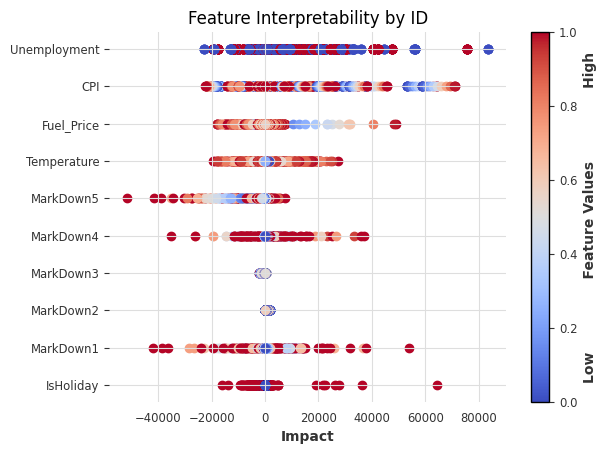

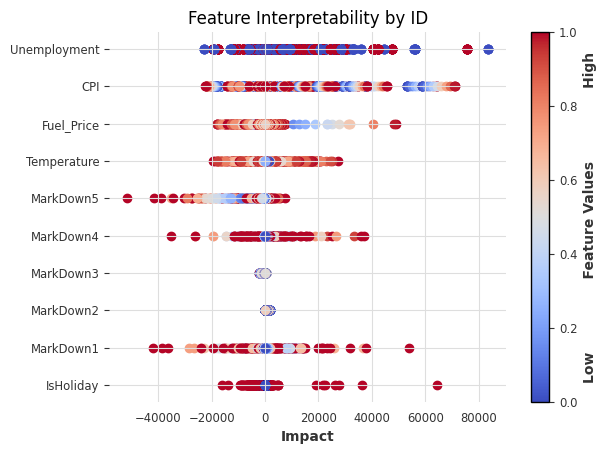

In [29]:
features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

df_test.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

summary_plot_serie(df_test,full_forecast_test[['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','ds','trend','yearly','yhat','id']],features,'ds',STATIC_COV)

In [100]:
store_selecionada = 2 
dept_selecionada= 1

# Filtrar o DataFrame para manter apenas os dados dessa loja
df2 = df_test[df_test['id'] == '2-1']

forecast2=full_forecast_test[full_forecast_test['id']=='2-1']

In [101]:
df2

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,id
3248,2,1,2012-07-13,23148.57,0,A,medium,80.17,3.256,8354.65,342.25,20.53,5674.44,5012.22,221.561678,6.565,2-1
3249,2,1,2012-07-20,23813.13,0,A,medium,83.23,3.311,6961.58,241.20,24.97,3401.36,2453.42,221.570112,6.565,2-1
3250,2,1,2012-07-27,23025.51,0,A,medium,86.37,3.407,6999.14,197.72,2.53,6319.33,5007.01,221.578546,6.565,2-1
3251,2,1,2012-08-03,22851.99,0,A,medium,90.22,3.417,27650.68,164.58,43.02,21801.90,6652.98,221.586980,6.565,2-1
3252,2,1,2012-08-10,23261.95,0,A,medium,88.55,3.494,5554.54,142.30,13.43,4187.43,5286.19,221.595414,6.565,2-1
3253,2,1,2012-08-17,24793.54,0,A,medium,84.79,3.571,4774.16,330.78,10.53,4253.28,4927.26,221.675146,6.565,2-1
3254,2,1,2012-08-24,22839.77,0,A,medium,76.91,3.620,4759.70,211.38,6.62,2972.88,5102.26,221.808352,6.565,2-1
3255,2,1,2012-08-31,25343.45,0,A,medium,82.64,3.638,17500.26,73.22,21.38,12878.62,4756.50,221.941558,6.565,2-1
3256,2,1,2012-09-07,25270.06,1,A,medium,87.65,3.730,10658.86,149.28,60.97,2920.90,3275.57,222.074763,6.565,2-1
3257,2,1,2012-09-14,26435.20,0,A,medium,75.88,3.717,8325.93,0.00,37.32,1808.69,9314.55,222.217440,6.565,2-1


In [102]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CPI,CPI_lower,CPI_upper,Fuel_Price,...,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,id
3248,2012-07-13,25355.050255,12146.915738,35688.224454,25355.050255,25355.050349,3988.658755,3988.658755,3988.658755,5.249125,...,7514.530622,7514.530622,-9286.739041,-9286.739041,-9286.739041,0.0,0.0,0.0,23582.841836,2-1
3249,2012-07-20,25264.716311,12588.369296,35633.923051,25264.715323,25264.717182,3993.652508,3993.652508,3993.652508,8.929994,...,8083.653419,8083.653419,-9362.974527,-9362.974527,-9362.974527,0.0,0.0,0.0,23985.395202,2-1
3250,2012-07-27,25174.382367,11109.880236,33898.829550,25174.379918,25174.384625,3998.646201,3998.646201,3998.646201,15.354784,...,7487.458089,7487.458089,-9957.123306,-9957.123306,-9957.123306,0.0,0.0,0.0,22704.717150,2-1
3251,2012-08-03,25084.048422,7253.166787,29691.109133,25084.043727,25084.052297,4003.639895,4003.639895,4003.639895,16.024033,...,3835.628921,3835.628921,-10466.536515,-10466.536515,-10466.536515,0.0,0.0,0.0,18453.140828,2-1
3252,2012-08-10,24993.714478,12103.842589,34732.037414,24993.707148,24993.720267,4008.633648,4008.633648,4008.633648,21.177250,...,8005.232921,8005.232921,-10268.496938,-10268.496938,-10268.496938,0.0,0.0,0.0,22730.450460,2-1
3253,2012-08-17,24903.380534,11797.351531,35714.476203,24903.371285,24903.388669,4055.843411,4055.843411,4055.843411,26.330467,...,7998.907426,7998.907426,-9547.520872,-9547.520872,-9547.520872,0.0,0.0,0.0,23354.767088,2-1
3254,2012-08-24,24813.046589,12331.160484,35640.144377,24813.034256,24813.057166,4134.715269,4134.715269,4134.715269,29.609787,...,8338.889252,8338.889252,-8850.869554,-8850.869554,-8850.869554,0.0,0.0,0.0,24301.066288,2-1
3255,2012-08-31,24722.712645,11553.926005,34476.916064,24722.697262,24722.725470,4213.587068,4213.587068,4213.587068,30.814435,...,6137.835711,6137.835711,-8111.497347,-8111.497347,-8111.497347,0.0,0.0,0.0,22749.051009,2-1
3256,2012-09-07,24632.378701,12908.252455,36207.572089,24632.360152,24632.394060,4292.458926,4292.458926,4292.458926,36.971526,...,6072.675511,6072.675511,-6788.600692,-6788.600692,-6788.600692,0.0,0.0,0.0,23916.453520,2-1
3257,2012-09-14,24542.044757,16564.061729,40051.145673,24542.023262,24542.062915,4376.938076,4376.938076,4376.938076,36.101502,...,8786.211316,8786.211316,-5096.243657,-5096.243657,-5096.243657,0.0,0.0,0.0,28232.012416,2-1


/var/folders/t4/3szz82nx3pqg5dxmwdcj_4dw0000gn/T/ipykernel_12628/3668384548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)


    Store  Dept         ds         y  IsHoliday_x Type    Size  Temperature_x  \
0       2     1 2012-07-13  23148.57            0    A  medium          80.17   
1       2     1 2012-07-20  23813.13            0    A  medium          83.23   
2       2     1 2012-07-27  23025.51            0    A  medium          86.37   
3       2     1 2012-08-03  22851.99            0    A  medium          90.22   
4       2     1 2012-08-10  23261.95            0    A  medium          88.55   
5       2     1 2012-08-17  24793.54            0    A  medium          84.79   
6       2     1 2012-08-24  22839.77            0    A  medium          76.91   
7       2     1 2012-08-31  25343.45            0    A  medium          82.64   
8       2     1 2012-09-07  25270.06            1    A  medium          87.65   
9       2     1 2012-09-14  26435.20            0    A  medium          75.88   
10      2     1 2012-09-21  26303.04            0    A  medium          71.09   
11      2     1 2012-09-28  

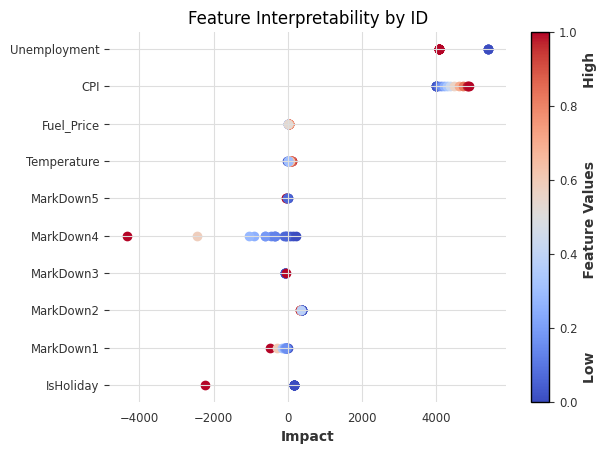

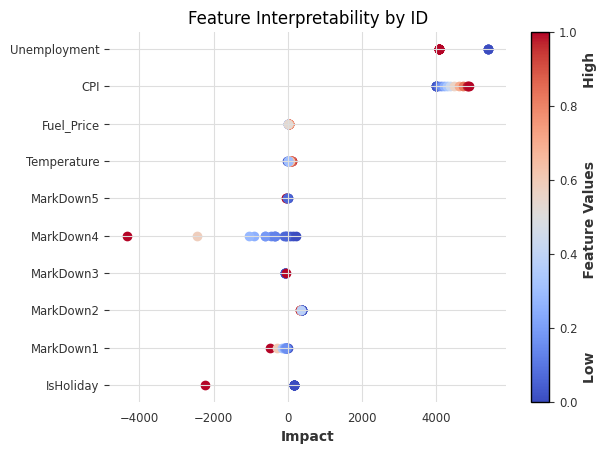

In [104]:
features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

df2.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

summary_plot_serie(df2,forecast2[['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment','ds','trend','yearly','yhat','id',]],features,'ds',STATIC_COV)

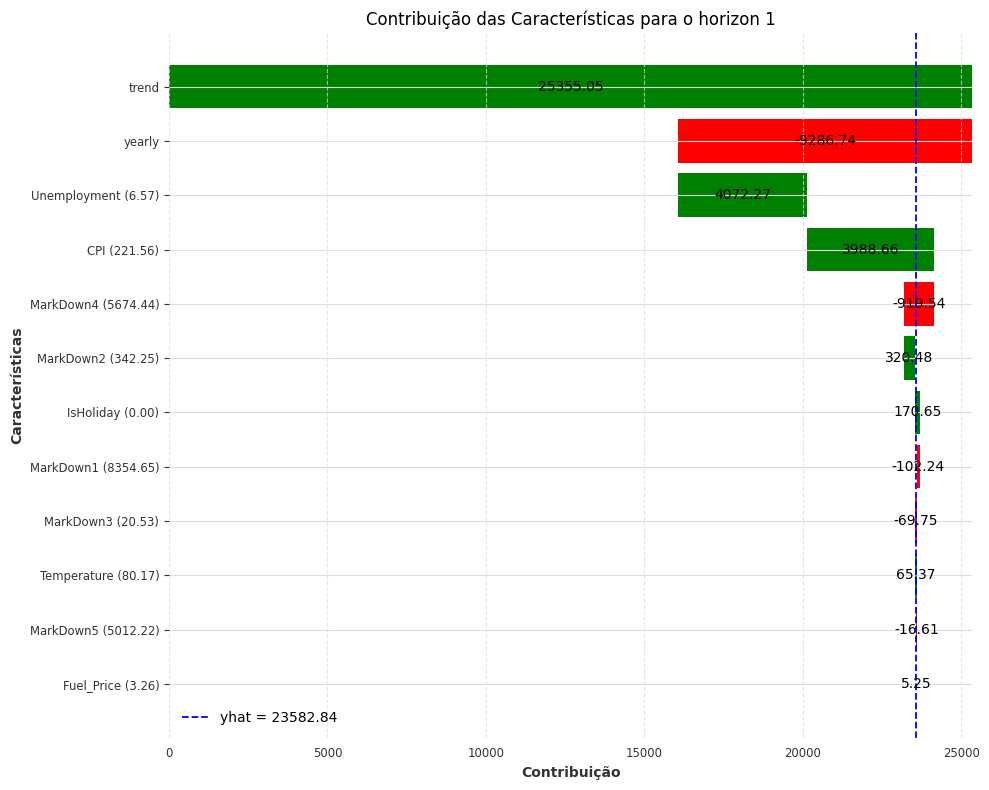

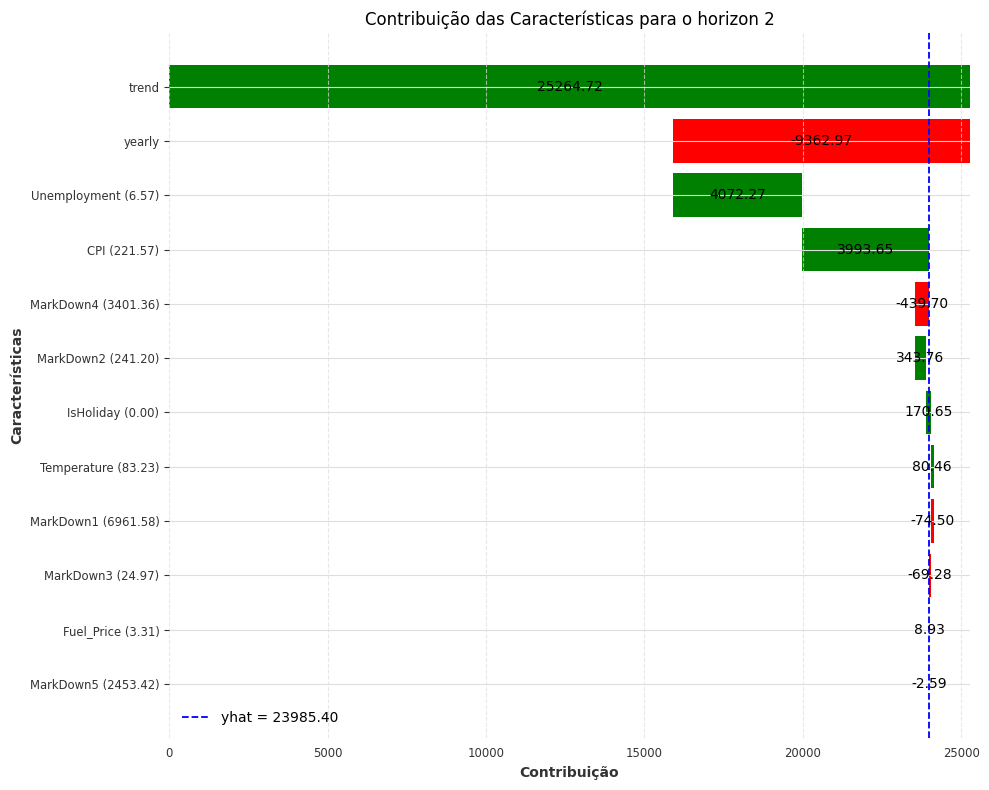

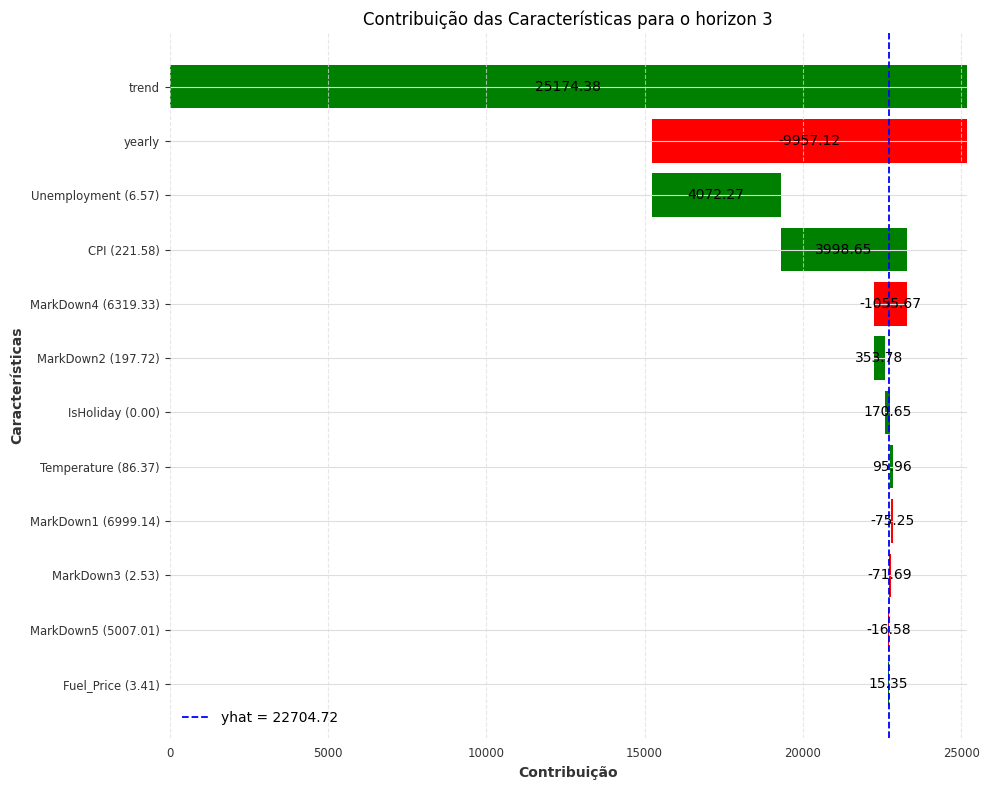

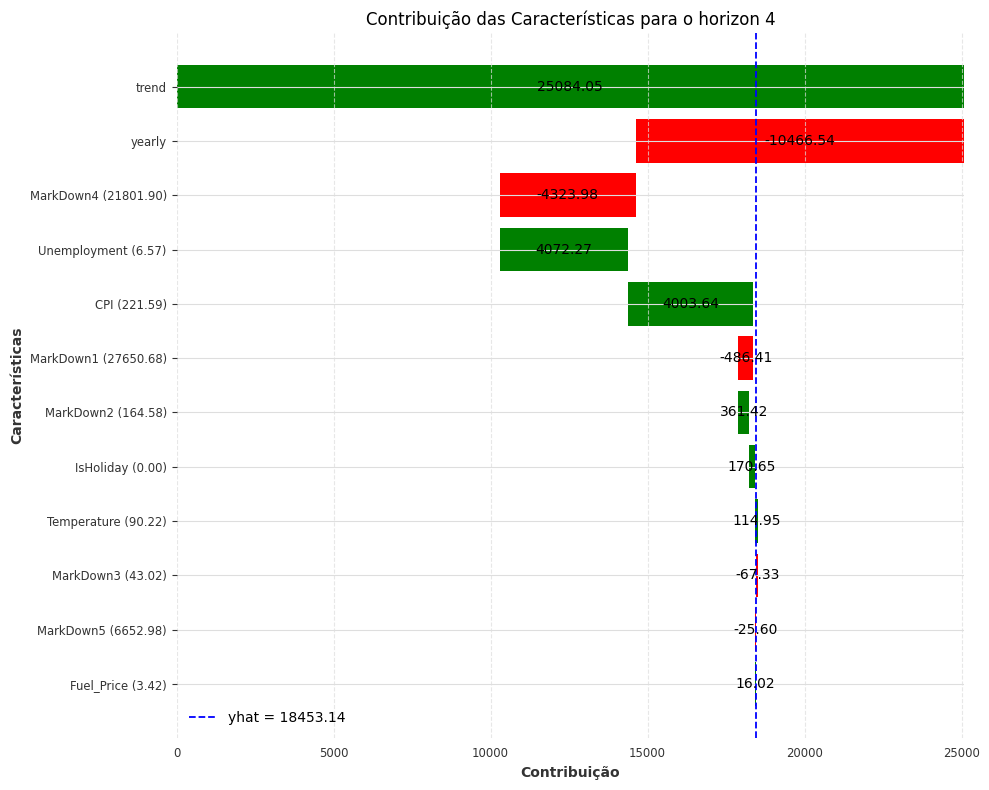

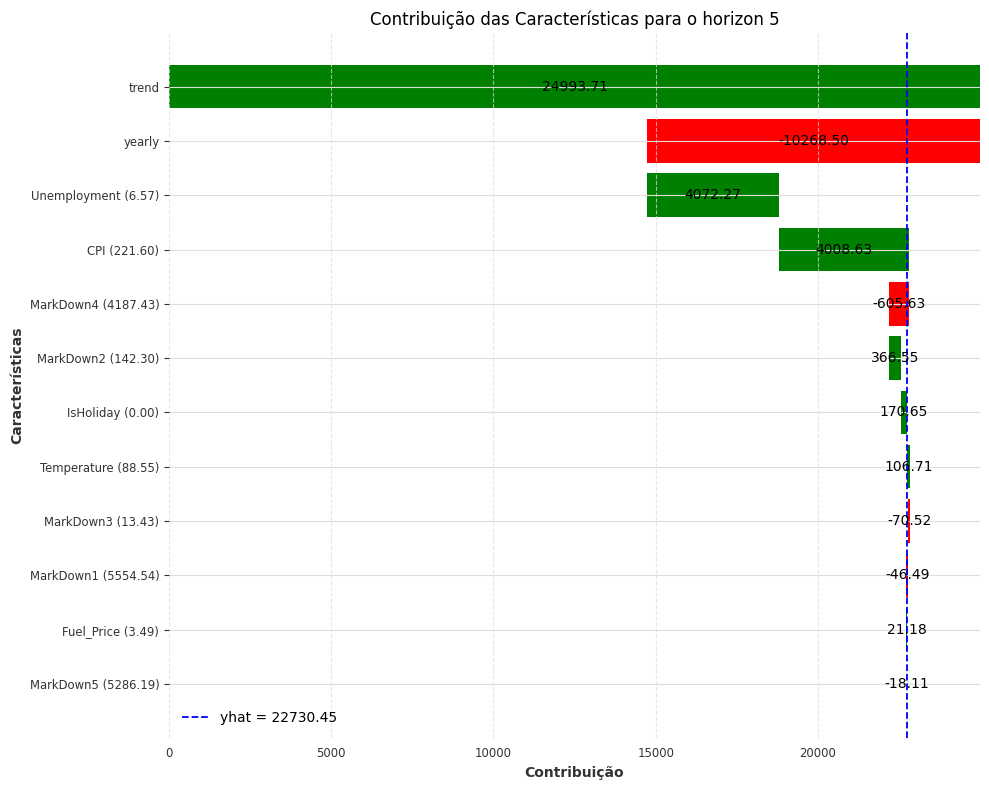

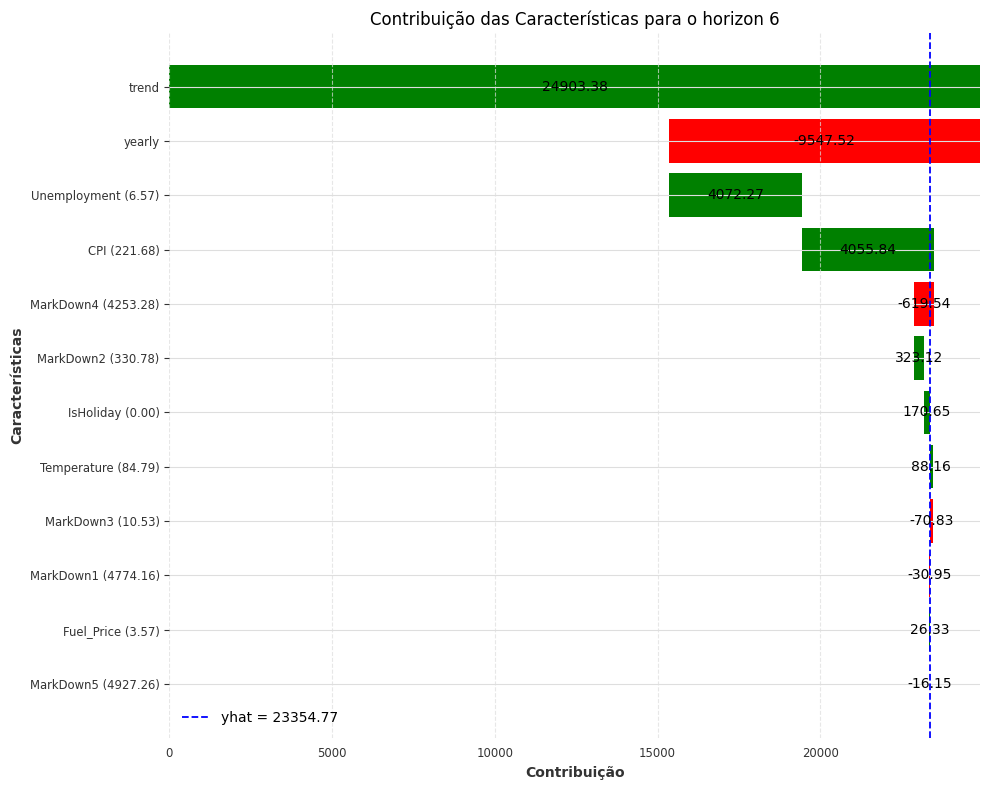

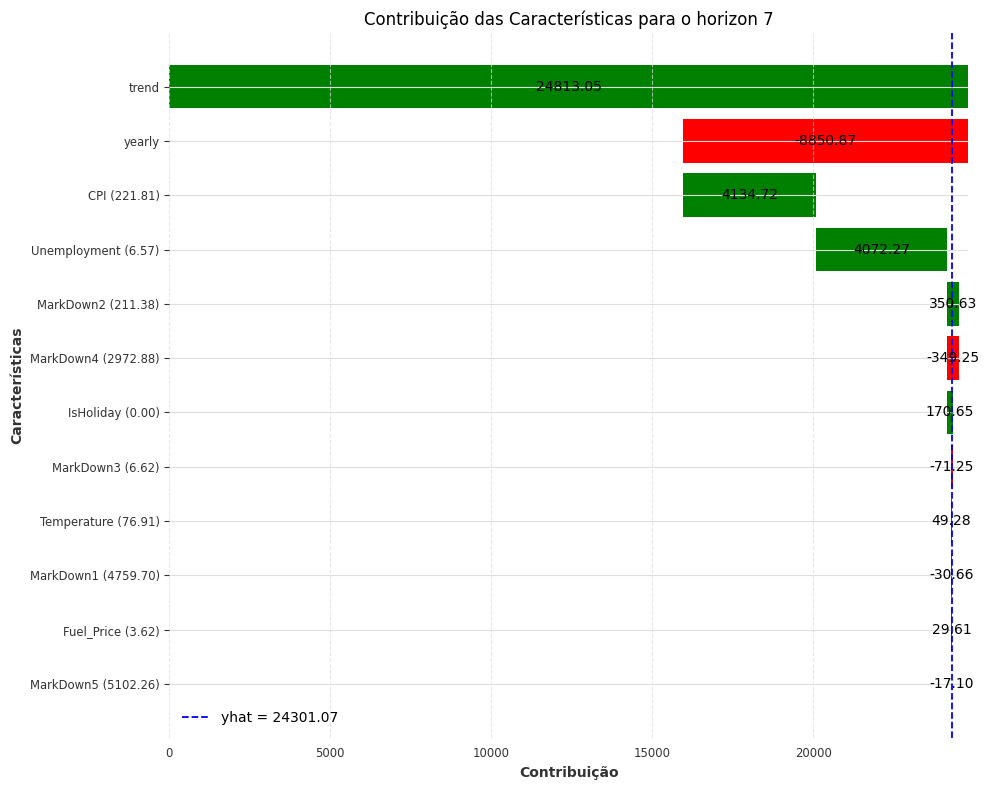

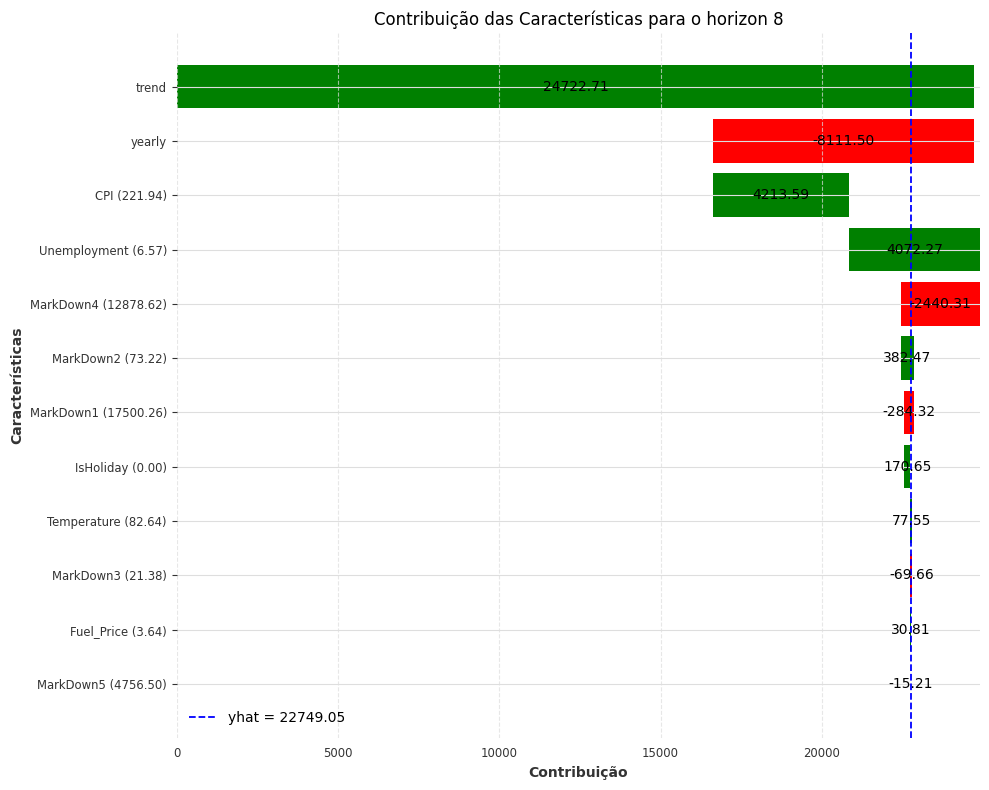

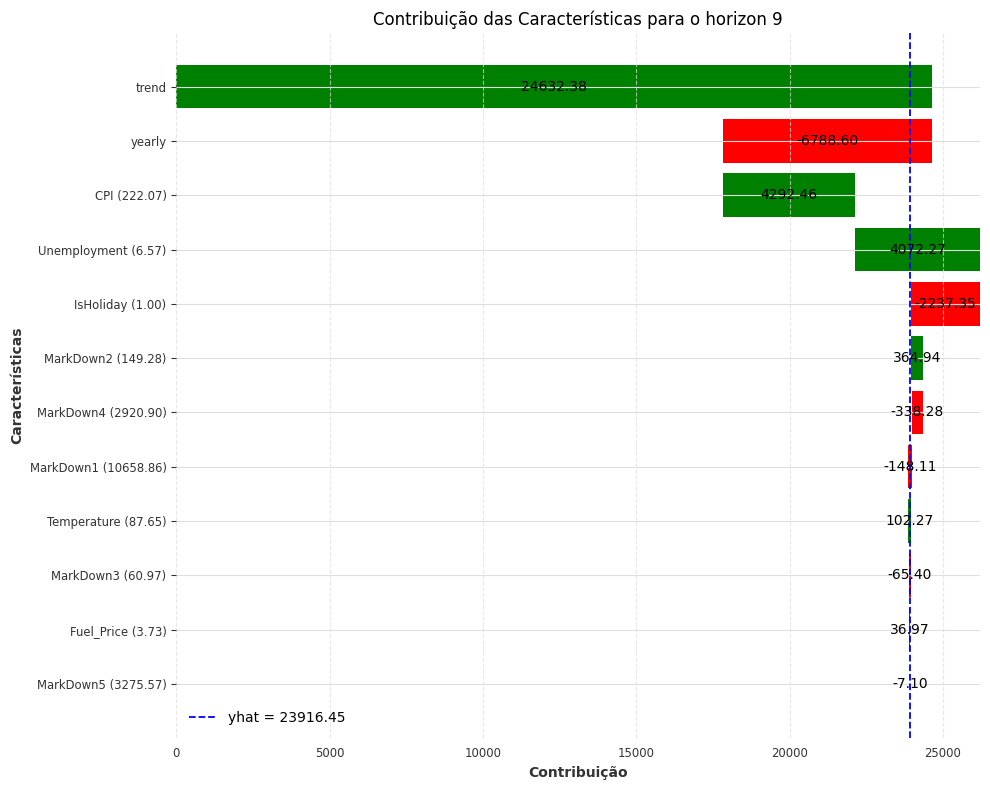

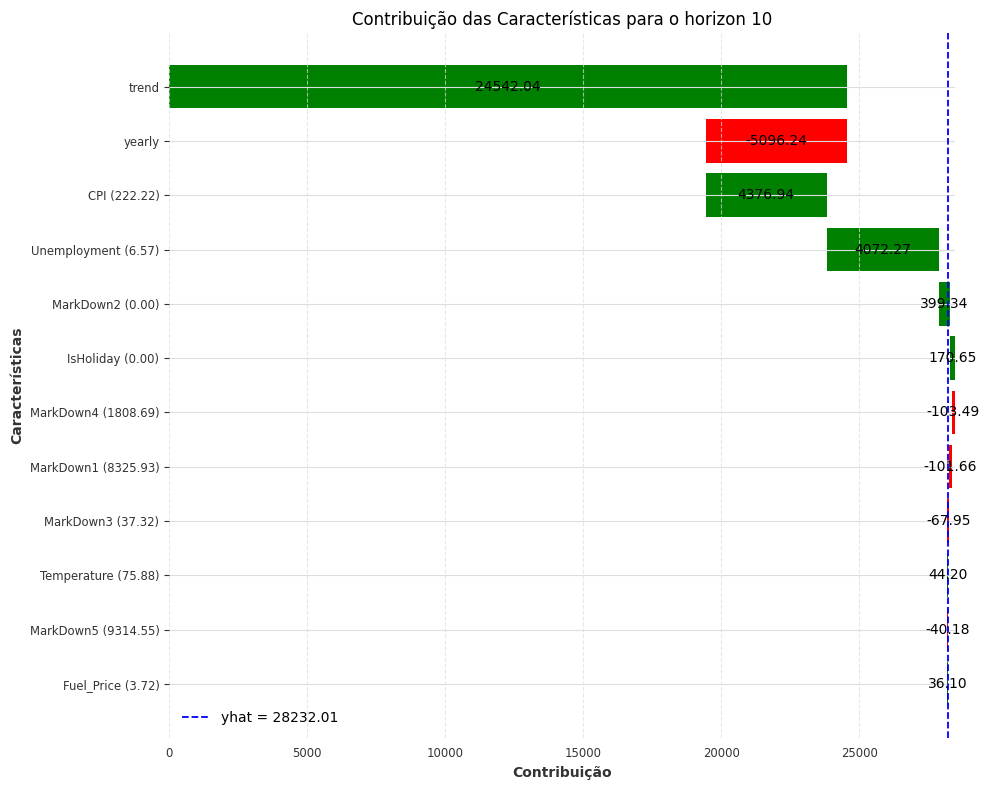

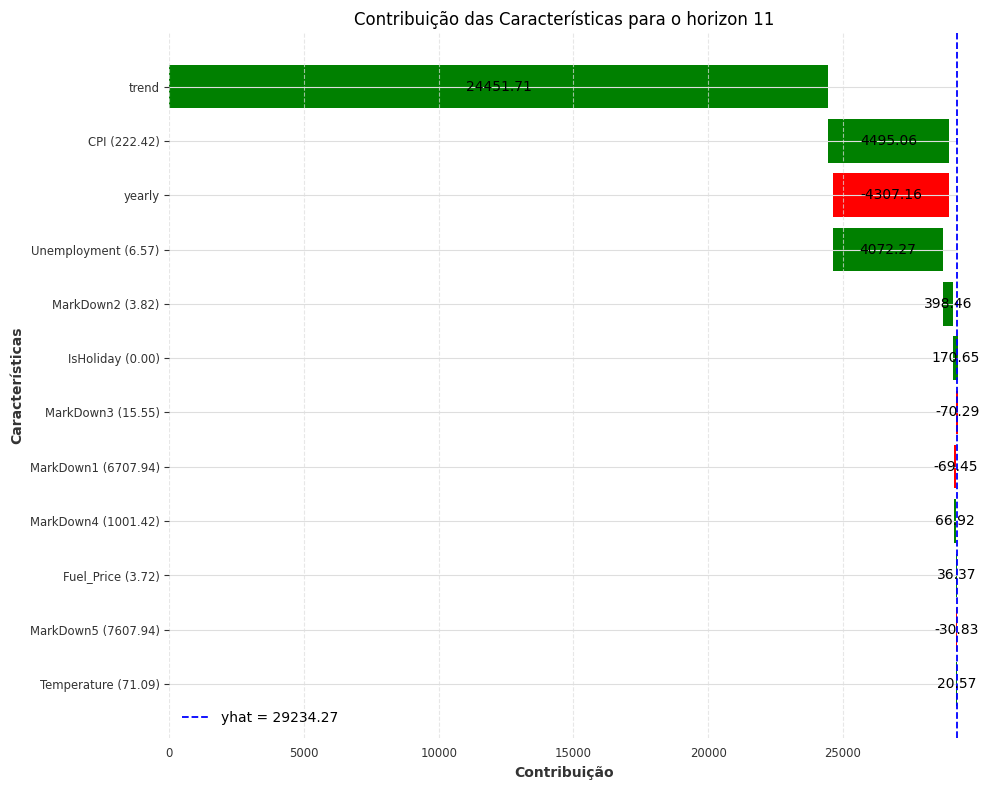

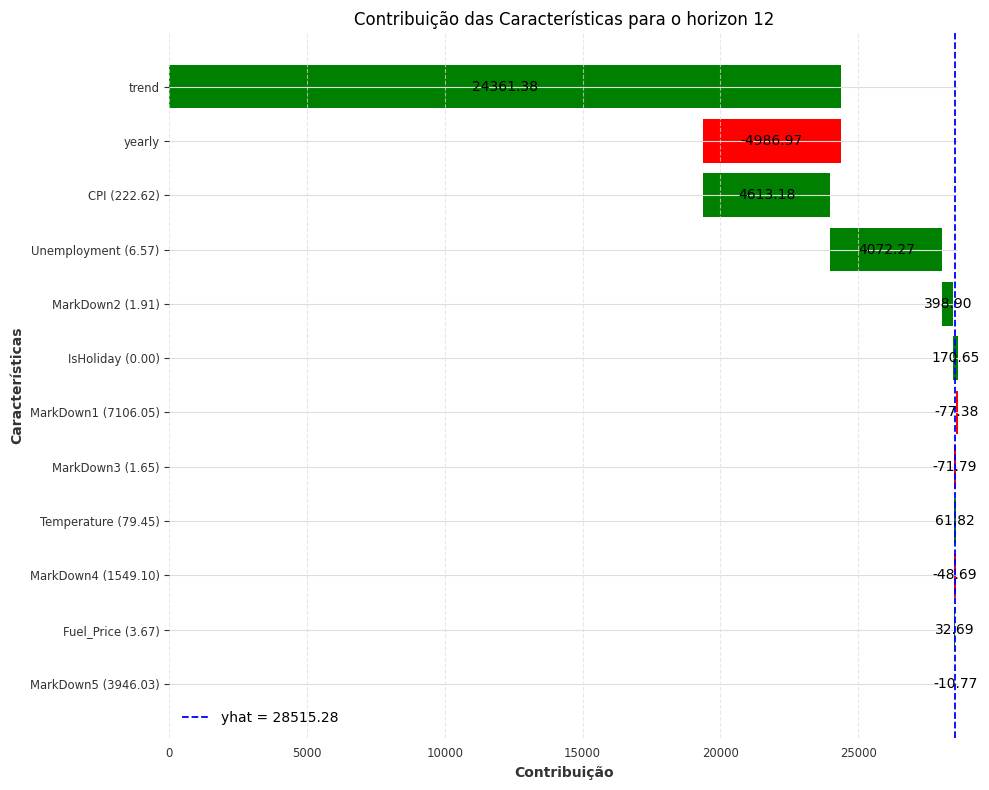

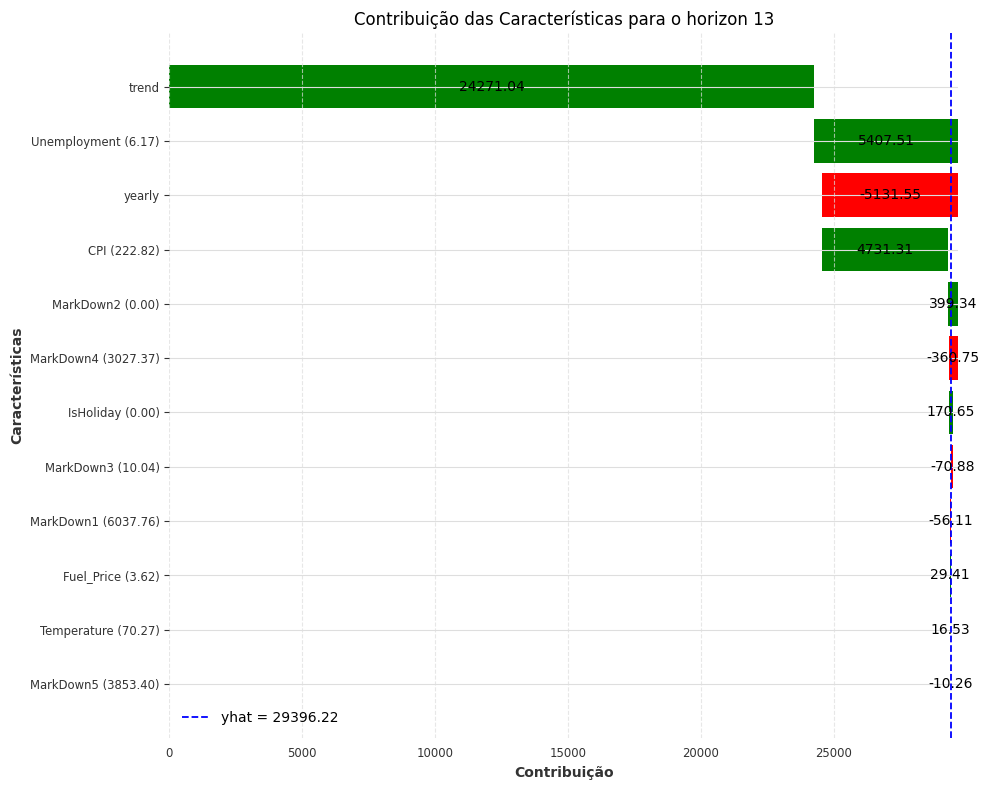

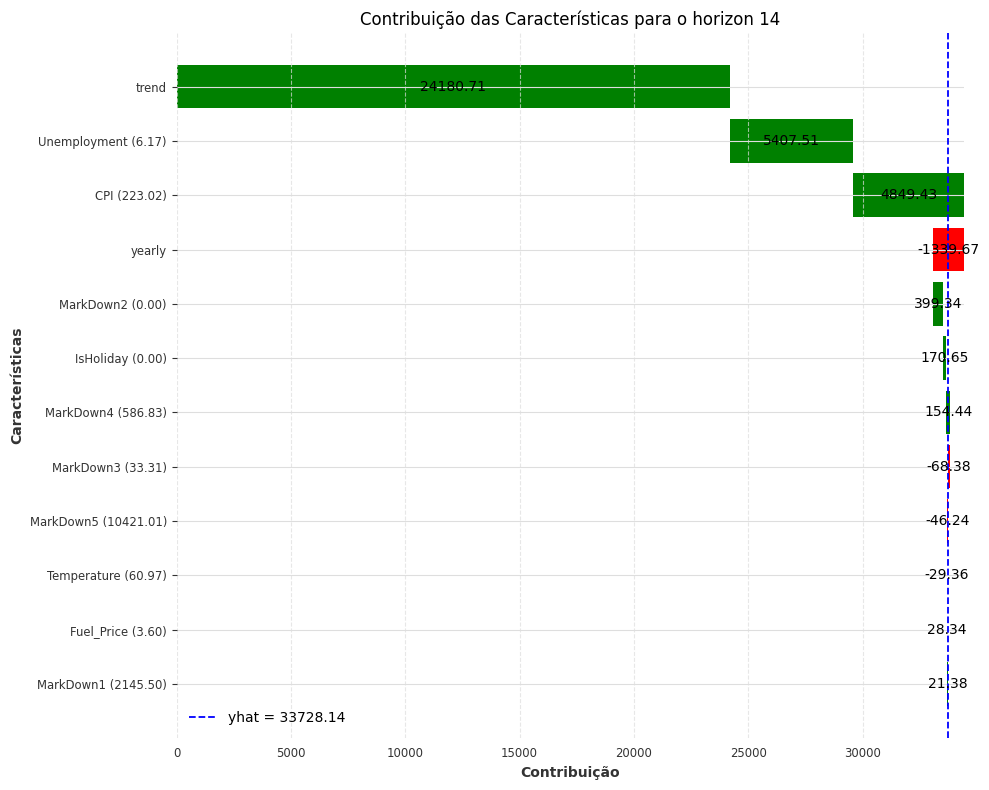

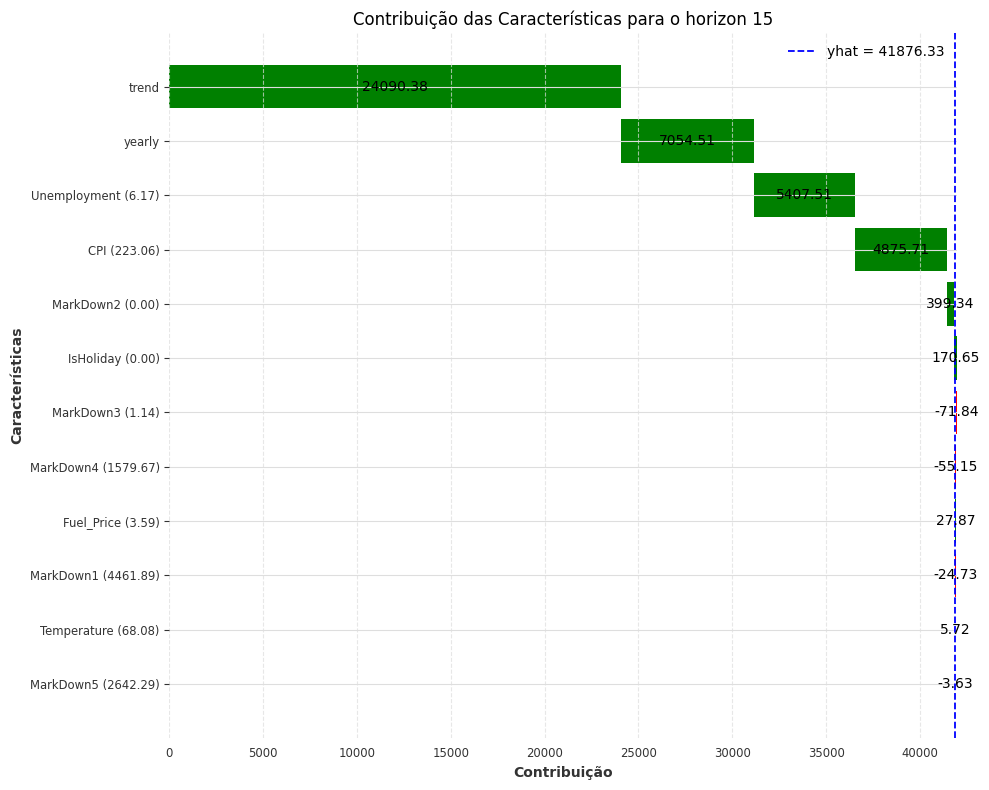

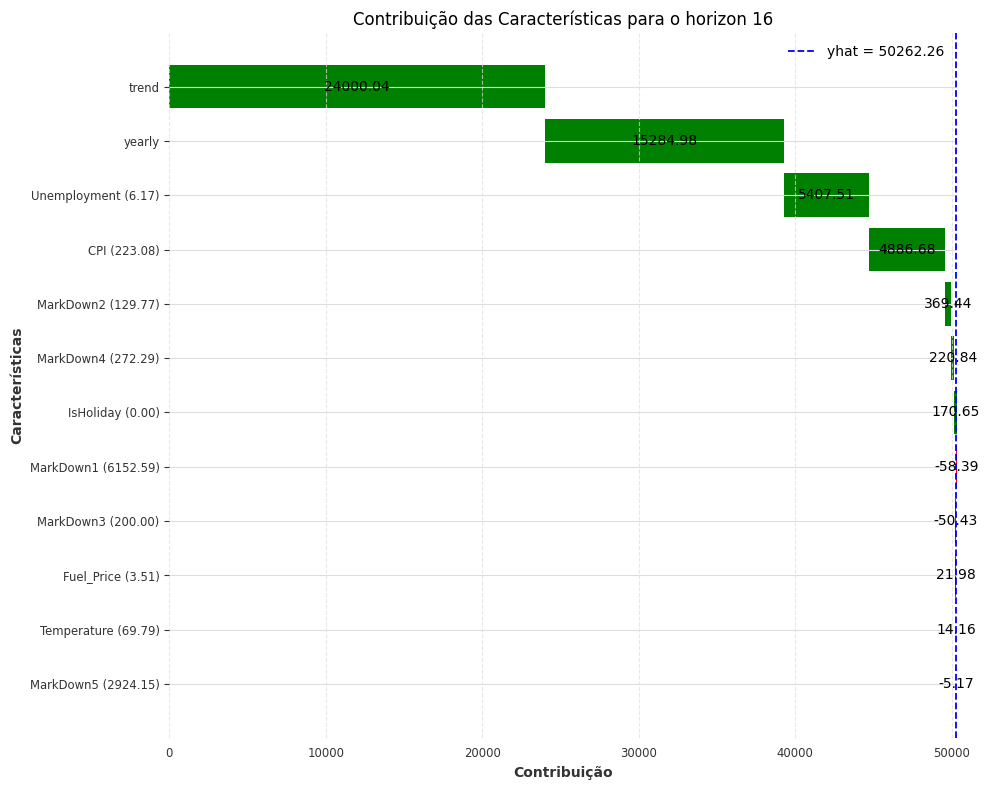

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

features = ['IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 
            'MarkDown5', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'trend', 'yearly']

last_16_forecast = forecast2.tail(16)[features + ['yhat']]
last_16_future_dates = df2.tail(16)

i = 1
for (index_forecast, row_forecast), (index_future_dates, row_future_dates) in zip(last_16_forecast.iterrows(), last_16_future_dates.iterrows()):
    fig, ax = plt.subplots(figsize=(10, 8))

    contributions = {}
    for feature in features:
        contributions[feature] = row_forecast[feature]

    sorted_features = sorted(contributions, key=lambda x: abs(contributions[x]), reverse=True)

    bars = []
    lefts = [0]  # Ponto inicial para a primeira barra
    y_labels = []

    for feature in sorted_features:
        bars.append(contributions[feature])
        if feature in row_future_dates:
            y_labels.append(f"{feature} ({row_future_dates[feature]:.2f})")
        else:
            y_labels.append(feature)  

    for idx in range(1, len(bars)):
        lefts.append(lefts[-1] + bars[idx-1])

    bars = np.array(bars)
    lefts = np.array(lefts)
    colors = ['green' if x >= 0 else 'red' for x in bars]

    # Inverta as listas aqui
    bars = bars[::-1]
    lefts = lefts[::-1]
    y_labels = y_labels[::-1]
    colors = colors[::-1]

    ax.barh(y=y_labels, width=bars, left=lefts, color=colors)
    for j in range(len(bars)):
        ax.text(lefts[j] + bars[j] / 2, j, f'{bars[j]:.2f}', va='center', ha='center', color='black')
    ax.axvline(x=row_forecast['yhat'], color='blue', linestyle='--', label=f'yhat = {row_forecast["yhat"]:.2f}')
    ax.legend()
    ax.set_title(f"Contribuição das Características para o horizon {i}")
    ax.set_xlabel('Contribuição')
    ax.set_ylabel('Características')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    i += 1


In [111]:
from sklearn.metrics import mean_squared_error

true_values = df2['y']
predictions = forecast2['yhat']

rmse = mean_squared_error(true_values, predictions, squared=False)

print(f"RMSE no conjunto de teste para id='2-1': {rmse}")

RMSE no conjunto de teste para id='2-1': 3151.8996463115895


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [108]:
df_test.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'id'],
      dtype='object')

In [113]:
from sklearn.metrics import mean_squared_error

real_values = df_test['y'].tolist()
predicted_values = full_forecast_test['yhat'].tolist()

rmse = mean_squared_error(real_values, predicted_values, squared=False)

print(f"RMSE no conjunto de teste: {rmse}")

RMSE no conjunto de teste: 5770.966610623458


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
